<h1><b>Sentiment Based Product Recommentdation System</b></h1>



<h2>1. Connect to Google drive<h2>

In [3]:
#importing colab libraries
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
filepath = '/content/drive/MyDrive/Colab Notebooks/Capstone/'

<h2>2. Importing Libraries</h2>

In [5]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import pickle
import time

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# To Check the most word occurence using word cloud
from wordcloud import WordCloud ,STOPWORDS



from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

from collections import Counter
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,f1_score,precision_score,accuracy_score, plot_confusion_matrix
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
pd.set_option('max_colwidth', 500)

<h2>3. Load Data</h2>

In [315]:
df = pd.read_csv(filepath + 'sample30.csv')
df.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive


In [316]:
df_attributes = pd.read_csv(filepath + 'Data+Attribute+Description.csv', encoding = "1250")

In [317]:
df_attributes

,Attribute,Attribute Description
0,id,Uniques identity number to identify each unique review given by the user to a particular product in the dataset
1,brand,Name of the brand of the product to which user has given review and rating
2,categories,"Category of the product like household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products, health care products and many more."
3,manufacturer,Name of the manufacturer of the product
4,name,Name of the product to which user has added review or rating
5,reviews_date,Date on which the review has been added by the user
6,reviews_didPurchase,Whether a particular user has purchased the product or not
7,reviews_doRecommend,Whether a particular user has recommended the product or not
8,reviews_rating,Rating given by the user to a particular product
9,reviews_text,Review given by the user to a particular product


<h2>4. Exploratory data analysis</h2>

In [318]:
#data shape
df.shape

(30000, 15)

In [319]:
#data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [320]:
#number of review
print("number of review texts:", len(df['reviews_text']))
print("number of review ratings:", len(df['reviews_rating']))
print("number of unique reviewer:", len(df['reviews_username'].unique()))

number of review texts: 30000
number of review ratings: 30000
number of unique reviewer: 24915


In [321]:
#look at unique values in each column
print('\nUnique values: \n', df.nunique())


Unique values: 
 id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64


Outcome:
* We can see that are 5 values in ratings
* 2 different sentiments
* Will have to treat missing values
* Products belong to 200+ brands
* Products belong to 200+ manufacturer

<b>Missing Values (%)</b>

In [322]:
#Null precentage
print("Percentage of missing values :")
print(df.isna().mean().round(4) * 100)

Percentage of missing values :
id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.47
name                     0.00
reviews_date             0.15
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.63
reviews_userCity        93.57
reviews_userProvince    99.43
reviews_username         0.21
user_sentiment           0.00
dtype: float64


In [323]:
sns.set_theme(style="darkgrid")

<b>Analyse Did Purchase</b>

In [324]:
print('Did Purchase distribution (%)')
print(round(df['reviews_didPurchase'].value_counts()/len(df['reviews_didPurchase']) * 100,2))
print('percentage of Missing Values(%):', round(df['reviews_didPurchase'].isna().sum()/len(df['reviews_didPurchase']) * 100,2))

Did Purchase distribution (%)
False    48.33
True      4.78
Name: reviews_didPurchase, dtype: float64
percentage of Missing Values(%): 46.89


"True" is only 4% of the total data which is very low. We will replace the missing values with "No Data" for our analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


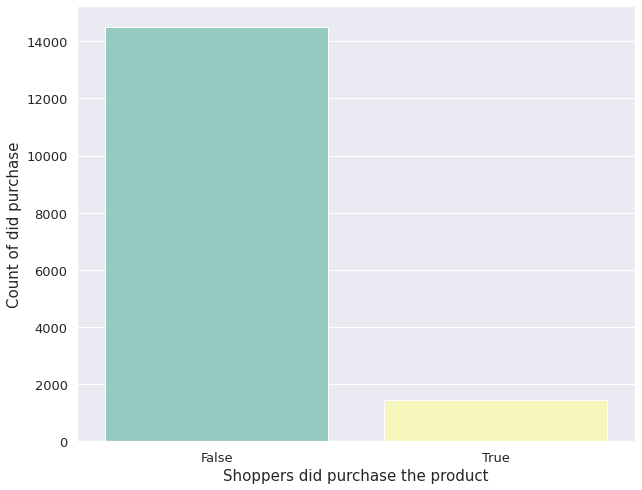

In [325]:
plt.figure(figsize=(10,8))
ax = sns.countplot(df['reviews_didPurchase'],palette="Set3")
ax.set_xlabel(xlabel="Shoppers did purchase the product", fontsize=15)
ax.set_ylabel(ylabel='Count of did purchase', fontsize=15)
ax.tick_params(labelsize=13)
plt.show()

Many people who have provided review have not purchased the product

Top products that were purchased:

Hormel Chili, No Beans                                                91
Coty Airspun Face Powder, Translucent Extra Coverage                  87
Chester's Cheese Flavored Puffcorn Snacks                             77
Tostitos Bite Size Tortilla Chips                                     59
Lysol Concentrate Deodorizing Cleaner, Original Scent                 55
Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks                    52
Bisquick Original Pancake And Baking Mix - 40oz                       46
Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz    41
Red (special Edition) (dvdvideo)                                      41
Bounce Dryer Sheets, Fresh Linen, 160 sheets                          36
Name: name, dtype: int64


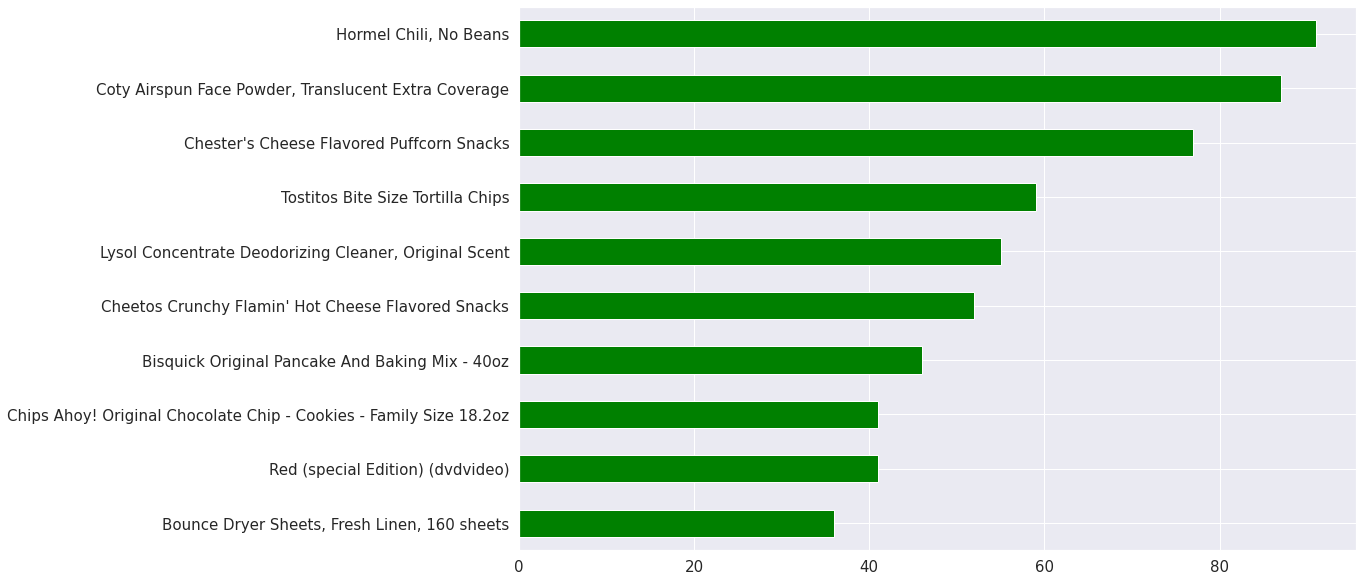

In [326]:
result = df[df['reviews_didPurchase'] == True]
print(result['name'].value_counts()[0:10])
result['name'].value_counts()[0:10].plot(kind = 'barh', figsize=[15,10], fontsize=15,color='Green').invert_yaxis()

Top purchased brands

Hormel                  91
Coty                    87
Tostitos                77
Chester's               77
Lysol                   55
Cheetos                 52
Bisquick                46
Chips Ahoy              41
Summit Entertainment    41
Bounce                  36
Name: brand, dtype: int64


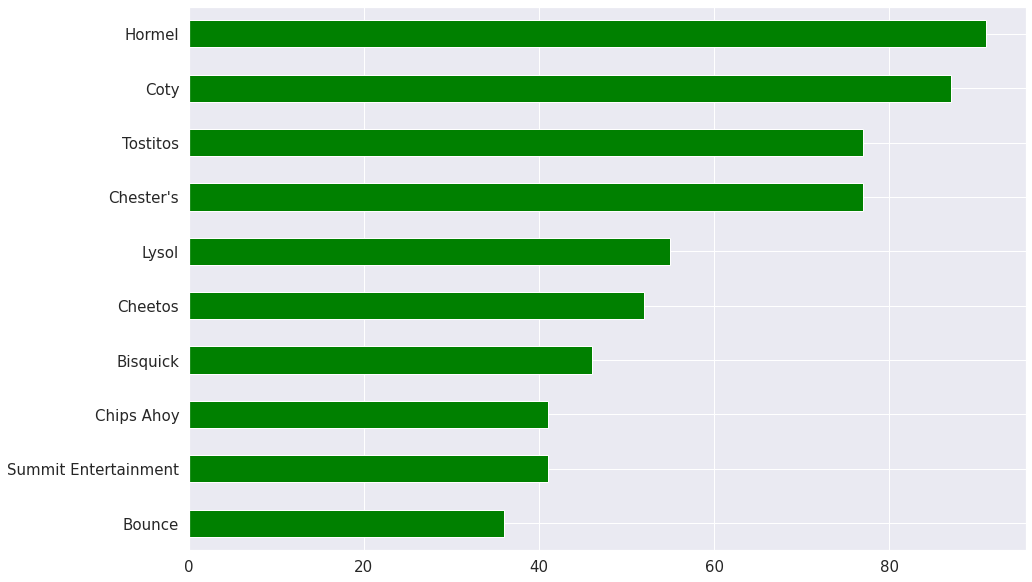

In [327]:
print(result['brand'].value_counts()[0:10])
result['brand'].value_counts()[0:10].plot(kind = 'barh', figsize=[15,10], fontsize=15,color='Green').invert_yaxis()

<b>Analyse Did Recommend</b>

In [328]:
print('Did Recommend distribution (%)')
print(round(df['reviews_doRecommend'].value_counts()/len(df['reviews_doRecommend']) * 100,2))
print('percentage of Missing Values (%):', round(df['reviews_doRecommend'].isna().sum()/len(df['reviews_doRecommend']) * 100,2))

Did Recommend distribution (%)
True     86.27
False     5.17
Name: reviews_doRecommend, dtype: float64
percentage of Missing Values (%): 8.57


Top products that were recommended:

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                         8492
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                   3098
Clorox Disinfecting Bathroom Cleaner                                              1995
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)               1124
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz     941
The Resident Evil Collection 5 Discs (blu-Ray)                                     827
Burt's Bees Lip Shimmer, Raisin                                                    764
Mike Dave Need Wedding Dates (dvd + Digital)                                       703
Red (special Edition) (dvdvideo)                                                   658
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                               634
Name: name, dtype: int64


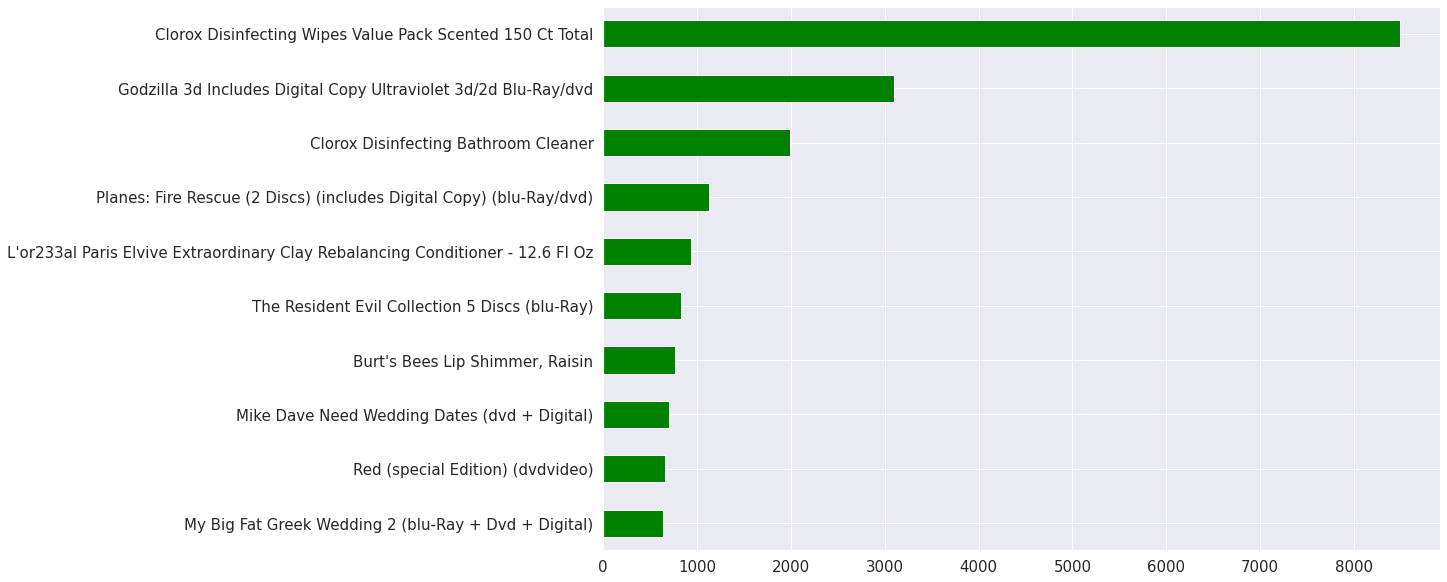

In [329]:
result = df[df['reviews_doRecommend'] == True]
print(result['name'].value_counts()[0:10])
result['name'].value_counts()[0:10].plot(kind = 'barh', figsize=[15,10], fontsize=15,color='Green').invert_yaxis()

<b>Analyse Ratings</b>

In [330]:
df["reviews_rating"].describe()

count    30000.000000
mean         4.483133
std          0.988441
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reviews_rating, dtype: float64

Rating distribution (%)
5    69.44
4    20.07
1     4.61
3     4.48
2     1.40
Name: reviews_rating, dtype: float64


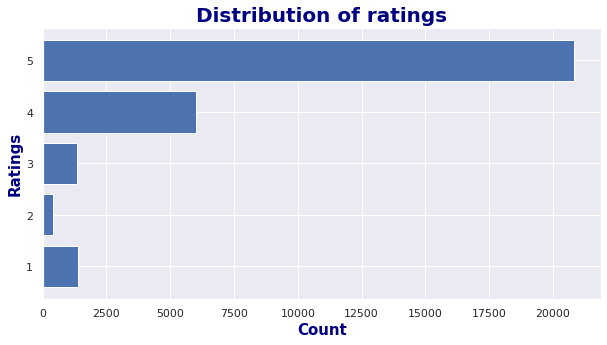

In [331]:
print('Rating distribution (%)')
print(round(df['reviews_rating'].value_counts()/len(df['reviews_rating']) * 100,2))

plt.figure(figsize=[10,5]) #[width, height]
x = list(df['reviews_rating'].value_counts().index)
y = list(df['reviews_rating'].value_counts())
plt.barh(x, y)
plt.title('Distribution of ratings', fontsize=20, weight='bold', color='navy', loc='center')
plt.xlabel('Count', fontsize=15, weight='bold', color='navy')
plt.ylabel('Ratings', fontsize=15, weight='bold', color='navy')
plt.show()

Maximum rating given by users are 5 for any product. 

<b>Analyse User sentiment</b>

In [332]:
#user_sentiment
print('User Sentiment distribution (%)')
print(round(df['user_sentiment'].value_counts()/len(df['user_sentiment']) * 100,2))

User Sentiment distribution (%)
Positive    88.77
Negative    11.22
Name: user_sentiment, dtype: float64


Top products with Positive sentiment

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                         7729
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                   3034
Clorox Disinfecting Bathroom Cleaner                                              1878
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1147
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)               1062
Burt's Bees Lip Shimmer, Raisin                                                    768
The Resident Evil Collection 5 Discs (blu-Ray)                                     686
Mike Dave Need Wedding Dates (dvd + Digital)                                       641
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                               641
Red (special Edition) (dvdvideo)                                                   638
Name: name, dtype: int64


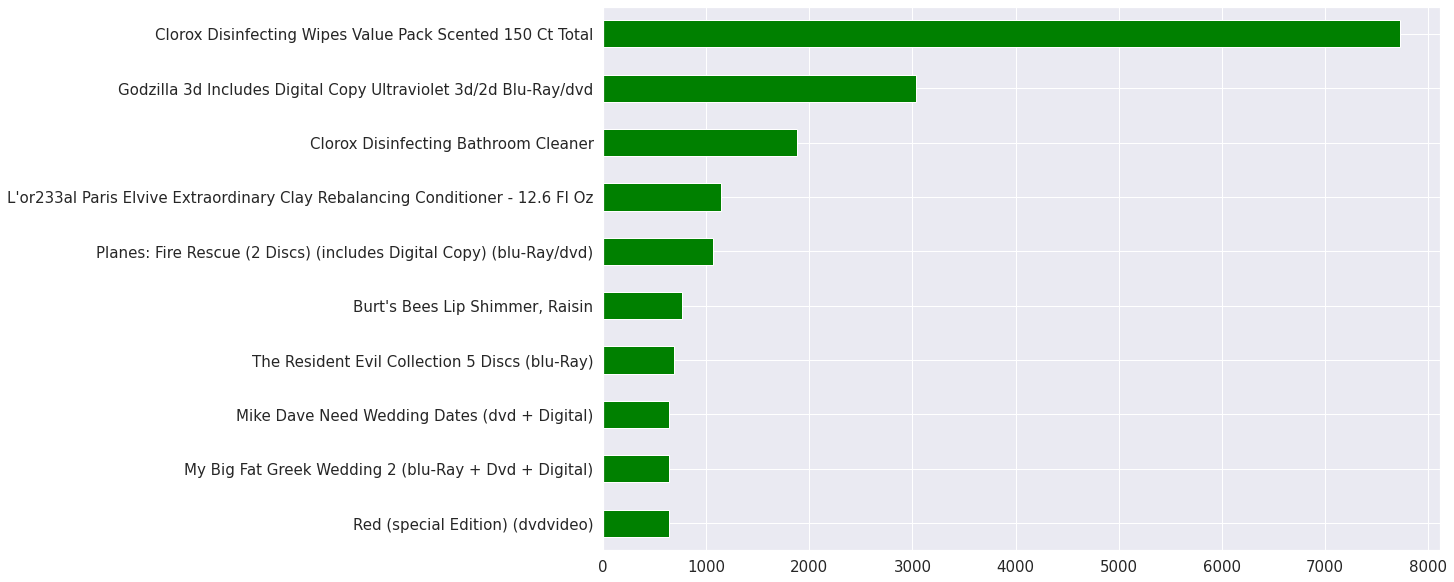

In [333]:
result = df[df['user_sentiment'] == 'Positive']
print(result['name'].value_counts()[0:10])
result['name'].value_counts()[0:10].plot(kind = 'barh', figsize=[15,10], fontsize=15,color='Green').invert_yaxis()

Top brand with Positive sentiment

Clorox                  9608
Warner Home Video       3034
L'oreal Paris           1147
Disney                  1115
Burt's Bees              776
FOX                      759
Summit Entertainment     755
Sony Pictures            686
Universal Home Video     641
Olay                     568
Name: brand, dtype: int64


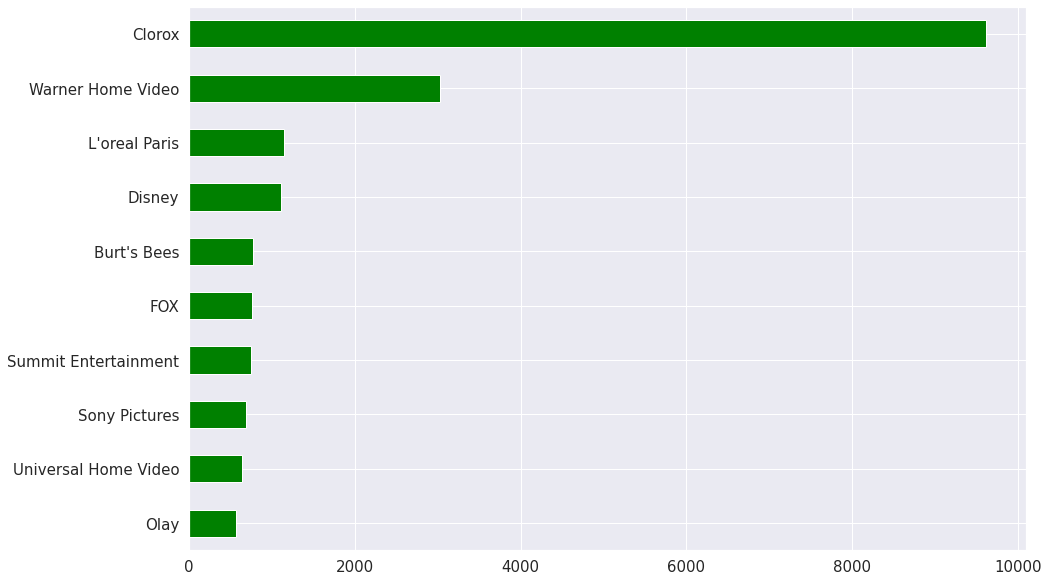

In [334]:
print(result['brand'].value_counts()[0:10])
result['brand'].value_counts()[0:10].plot(kind = 'barh', figsize=[15,10], fontsize=15,color='Green').invert_yaxis()

Top products with Negative sentiment

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                             816
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                       291
Nexxus Exxtra Gel Style Creation Sculptor                                             288
Clorox Disinfecting Bathroom Cleaner                                                  161
The Resident Evil Collection 5 Discs (blu-Ray)                                        159
Mike Dave Need Wedding Dates (dvd + Digital)                                          116
Burt's Bees Lip Shimmer, Raisin                                                       105
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz     92
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                    80
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                                  70
Name: name, dtype: int64


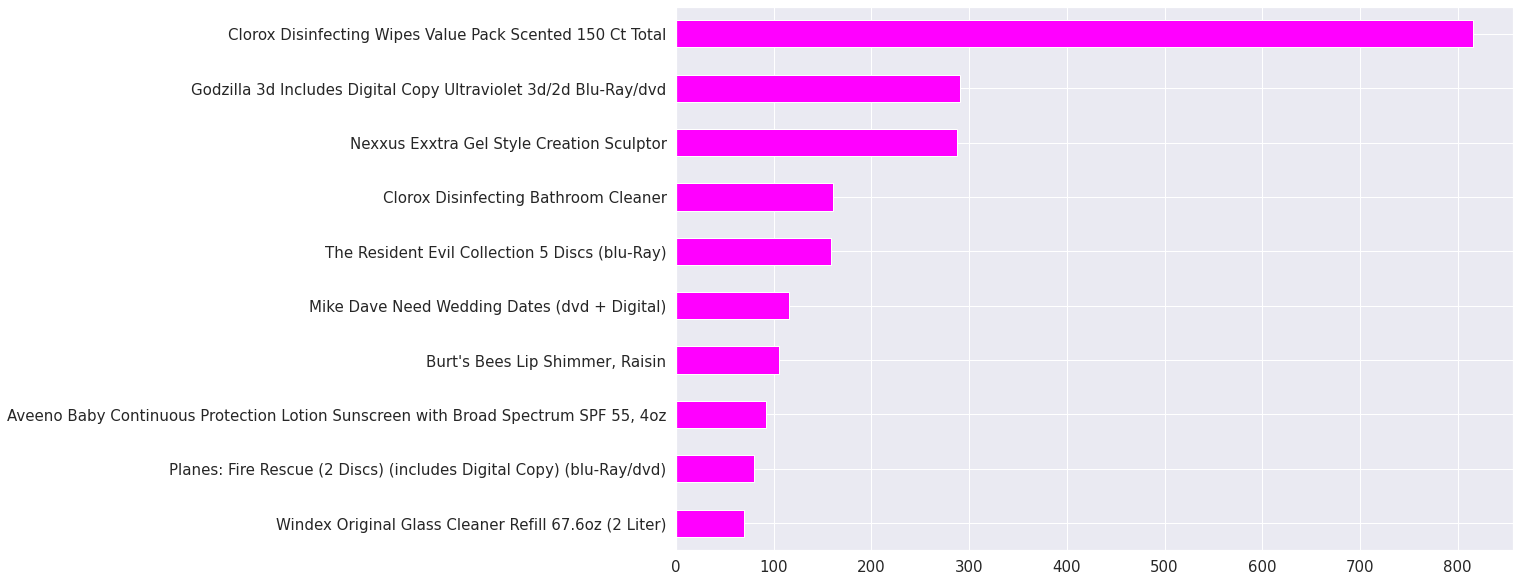

In [335]:
result = df[df['user_sentiment'] == 'Negative']
print(result['name'].value_counts()[0:10])
result['name'].value_counts()[0:10].plot(kind = 'barh', figsize=[15,10], fontsize=15,color='Magenta').invert_yaxis()

Top band with negative sentiment

Clorox               977
Warner Home Video    291
Nexxus               288
Sony Pictures        159
FOX                  128
Burt's Bees          105
Aveeno                92
Disney                84
Windex                70
Olay                  69
Name: brand, dtype: int64


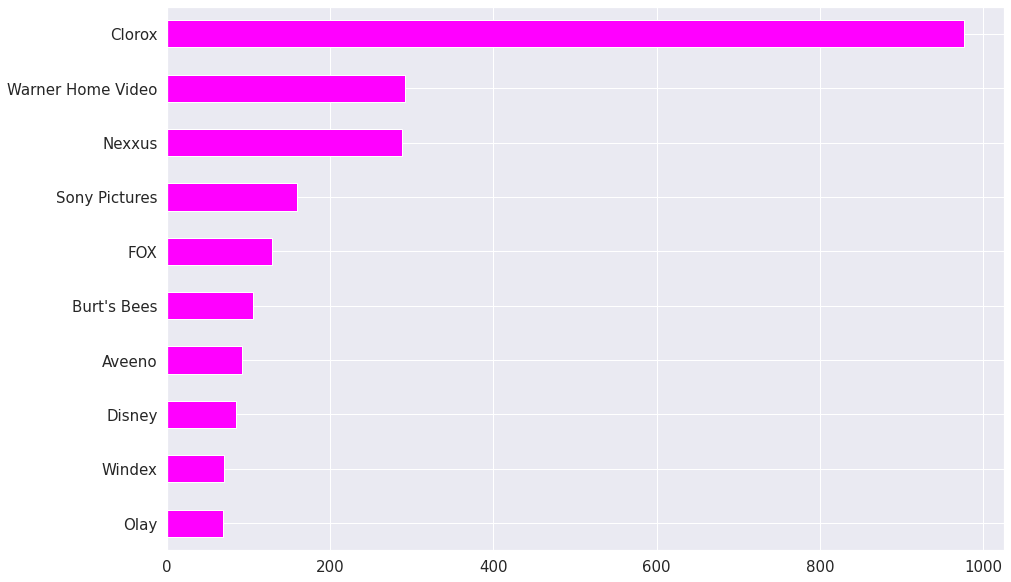

In [336]:
print(result['brand'].value_counts()[0:10])
result['brand'].value_counts()[0:10].plot(kind = 'barh', figsize=[15,10], fontsize=15,color='Magenta').invert_yaxis()

<b>Analyse other columns</b>

In [337]:
df["manufacturer"].value_counts()[:10]

Clorox                    8546
Test                      3325
AmazonUs/CLOO7            2039
L'oreal Paris             1232
Walt Disney               1143
Burt's Bees                873
SONY CORP                  845
Twentieth Century Fox      757
P&G                        730
Nexxus Beauty Products     693
Name: manufacturer, dtype: int64

In [338]:
df["reviews_username"].value_counts()[:10]

mike                 41
byamazon customer    41
chris                32
lisa                 16
sandy                15
tony                 15
rick                 15
dave                 14
john                 14
jojo                 13
Name: reviews_username, dtype: int64

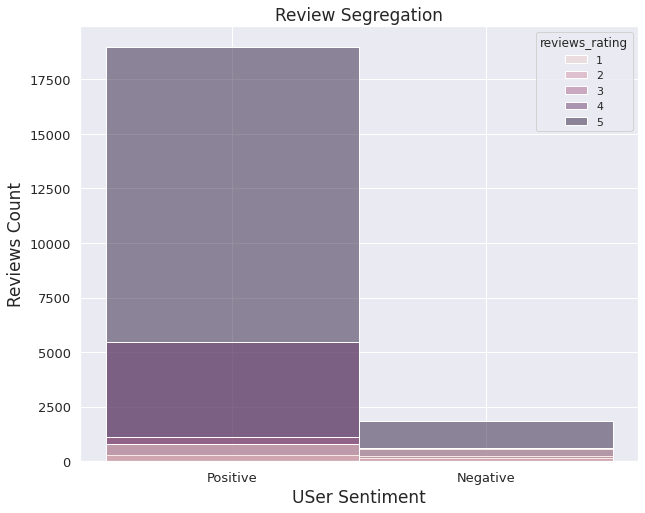

In [339]:
plt.figure(figsize=(10,8))
ax = sns.histplot(hue=df['reviews_rating'],x=df['user_sentiment'])
ax.set_xlabel(xlabel="USer Sentiment", fontsize=17)
ax.set_ylabel(ylabel='Reviews Count', fontsize=17)
ax.axes.set_title('Review Segregation', fontsize=17)
ax.tick_params(labelsize=13)

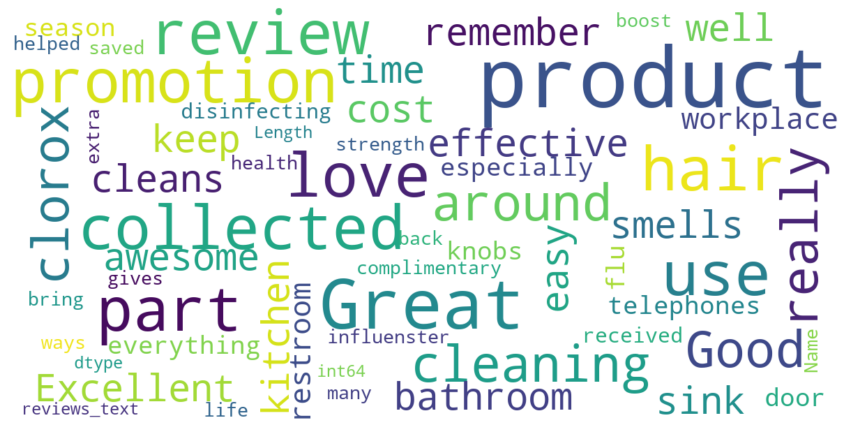

In [340]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=300, max_font_size=40,
                     scale=3, random_state=1).generate(str(df['reviews_text'].value_counts()))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

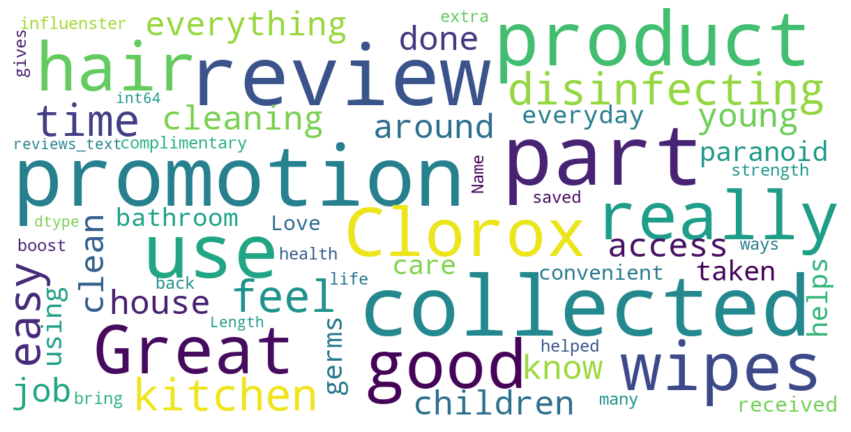

In [341]:
#word cloud for review where user sentiment was positive
wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=300, max_font_size=40,
                     scale=3, random_state=1).generate(str(df[df['user_sentiment'] == 'Positive']['reviews_text'].value_counts()))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

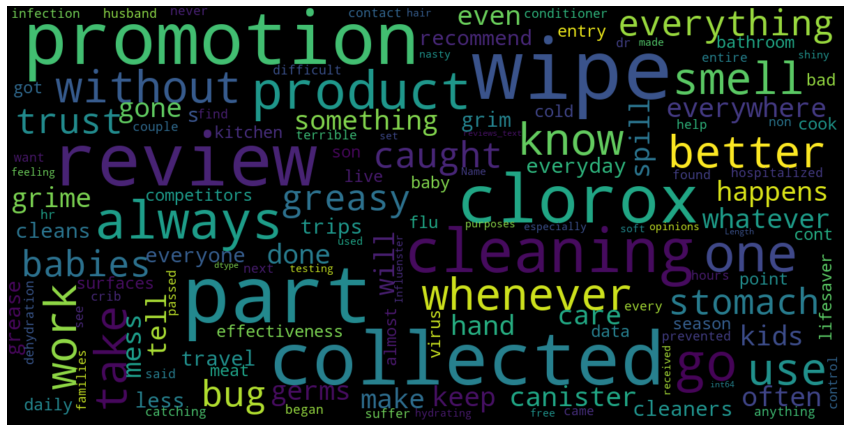

In [342]:
#word cloud for review where user sentiment was negative
wordcloud = WordCloud(background_color='black', stopwords=stopwords, max_words=300, max_font_size=40,
                     scale=3, random_state=1).generate(str(df[df['user_sentiment'] == 'Negative']['reviews_text'].value_counts()))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<h2>5. Data Preprocessing</h2>
<b>Missing Values Treatment</b>

In [343]:
print("Missing Value Count:")
print(df.isnull().sum())

Missing Value Count:
id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64


In [344]:
# Replace nulls in title will a blank space
df['reviews_title'].fillna('',inplace=True)

In [345]:
# Drop the columns with less than 20% of values
df.dropna(thresh = len(df) * .2, axis = 1, inplace = True)
print(df.isna().mean().round(4) * 100)

id                      0.00
brand                   0.00
categories              0.00
manufacturer            0.47
name                    0.00
reviews_date            0.15
reviews_didPurchase    46.89
reviews_doRecommend     8.57
reviews_rating          0.00
reviews_text            0.00
reviews_title           0.00
reviews_username        0.21
user_sentiment          0.00
dtype: float64


In [346]:
# In reviews_didPurchase, we will replace null values to False as infered in above analysis

df['reviews_didPurchase'] = df['reviews_didPurchase'].fillna('No Data')
df.reviews_didPurchase.unique()

array(['No Data', True, False], dtype=object)

In [347]:
#on the reviews_doRecommend column, replace null values with "No Data"
df['reviews_doRecommend'].fillna('No Data', inplace=True)

In [348]:
#Dropping the review date

df.drop('reviews_date', axis=1, inplace=True)

In [349]:
#<b>Fix the issue with user sentiment and rating</b>
# for correcting the user sentiment according to rating 
'''def review_sentiment_clear(x):
  if x >= 3 :
    return 'Positive'
  elif x > 0 and x < 3  :
    return 'Negative' '''

"def review_sentiment_clear(x):\n  if x >= 3 :\n    return 'Positive'\n  elif x > 0 and x < 3  :\n    return 'Negative' "

In [350]:
'''df['user_sentiment'] = df['reviews_rating'].apply(review_sentiment_clear)'''

"df['user_sentiment'] = df['reviews_rating'].apply(review_sentiment_clear)"

In [351]:
'''plt.figure(figsize=(10,8))
ax = sns.histplot(hue=df['reviews_rating'],x=df['user_sentiment'])
ax.set_xlabel(xlabel="User Sentiment", fontsize=17)
ax.set_ylabel(ylabel='Reviews Count', fontsize=17)
ax.axes.set_title('Review Segregation', fontsize=17)
ax.tick_params(labelsize=13)'''

'plt.figure(figsize=(10,8))\nax = sns.histplot(hue=df[\'reviews_rating\'],x=df[\'user_sentiment\'])\nax.set_xlabel(xlabel="User Sentiment", fontsize=17)\nax.set_ylabel(ylabel=\'Reviews Count\', fontsize=17)\nax.axes.set_title(\'Review Segregation\', fontsize=17)\nax.tick_params(labelsize=13)'

In [352]:
df.isna().sum()

id                       0
brand                    0
categories               0
manufacturer           141
name                     0
reviews_didPurchase      0
reviews_doRecommend      0
reviews_rating           0
reviews_text             0
reviews_title            0
reviews_username        63
user_sentiment           1
dtype: int64

In [353]:
df.dropna(inplace=True)
df.isna().sum()

id                     0
brand                  0
categories             0
manufacturer           0
name                   0
reviews_didPurchase    0
reviews_doRecommend    0
reviews_rating         0
reviews_text           0
reviews_title          0
reviews_username       0
user_sentiment         0
dtype: int64

In [354]:
df.shape

(29795, 12)

In [355]:
df['user_sentiment'].value_counts()

Positive    26462
Negative     3333
Name: user_sentiment, dtype: int64

In [356]:
'''df['user_sentiment'].map({'Positive':1,'Negative':0})'''

"df['user_sentiment'].map({'Positive':1,'Negative':0})"

In [357]:
#map the categorical user_sentiment to numerical 1 or 0 for modelling
df['user_sentiment'] = df['user_sentiment'].map({'Positive':1,'Negative':0})

In [358]:
df['user_sentiment'].value_counts()

1    26462
0     3333
Name: user_sentiment, dtype: int64

<h2>6. Text Preprocessing</h2>

In [359]:
df["reviews_full"] = df[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')

In [360]:
df[["reviews_full", "user_sentiment"]].sample(10)

,reviews_full,user_sentiment
4008,Great Organizational Tool. This file folder system allows me to organize my investigation files!,0
3021,"great movie. funny, great laughs, and Windex fixes everything, would watch it again.",1
28960,"Works ok, but not hydrating enough for me. I was excited to try this line, as it is intend d for my exact hair type-- oily roots and dry ends. However, this conditioner was not hydrating enough for me. I have color-treated hair, and my strands were left feeling a bit too dry atvtge ends after using this. Additionally, my hair was just as oily as usual, upon inspection 24 hours later.This conditioner was ok, but nothing special for me I would not repurchase. I received this for free fromInflu...",1
14699,great product. I usually use the Clorox wipes and they are wonderful for disinfecting. This review was collected as part of a promotion.,1
18710,"Super convenient!. These wipes are wet enough without being too wet, smell good, and clean very well. I only wish they had a tiny bit more texture for grabbing dust and particles on my counters.",1
13750,Disinfects. I like using this product because it helps disinfect my surrounding around the house especially when I have young kids in the house. This review was collected as part of a promotion.,1
27722,Great kids movie. Wonderful kids movie that parents can watch with them and enjoy as well.,1
17717,Great. Product is great used it for years just wish my local.store carried the product but as long as I can order on lineIm good,1
4789,Disc set will be a collectors item. This 5 disc set is fantastic! Well worth the money....will be a collectors item,1
13849,"love it. I love to cook and at times, the stove is full of grease splatter. With the clorox wipes, make it easy and quick for clean up!! This review was collected as part of a promotion.",1


In [361]:
#function to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub("\[\s*\w*\s*\]", "", text)
    dictionary = "abc".maketrans('', '', string.punctuation)
    text = text.translate(dictionary)
    text = re.sub("\S*\d\S*", "", text)
    
    return text

In [362]:
df_clean = df[['id','name', 'reviews_full', 'user_sentiment']]

In [363]:
df_clean["reviews_text"] = df_clean.reviews_full.apply(lambda x: clean_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [364]:
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [365]:
def remove_stopword(text):
    words = [word for word in text.split() if word.isalpha() and word not in stopwords]
    return " ".join(words)

In [366]:
lemmatizer = WordNetLemmatizer()
# Lemmatize the sentence
def lemma_text(text):
    word_pos_tags = nltk.pos_tag(word_tokenize(remove_stopword(text))) # Get position tags
    # Map the position tag and lemmatize the word/token
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(words)

In [367]:
df_clean["reviews_text_cleaned"] = df_clean.reviews_text.apply(lambda x: lemma_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [368]:
df_clean.head()

,id,name,reviews_full,user_sentiment,reviews_text,reviews_text_cleaned
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,1,just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it rating all the way her metaphors are just crazy,awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor. This review was collected as part of a promotion.,1,good good flavor this review was collected as part of a promotion,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor.,1,good good flavor,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,"Disappointed. I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captiva...",0,disappointed i read through the reviews on here before looking in to buying one of the couples lubricants and was ultimately disappointed that it didnt even live up to the reviews i had read for starters neither my boyfriend nor i could notice any sort of enhanced or captivating sensation what we did notice however was the messy consistency that was reminiscent of a more liquidy vaseline it was difficult to clean up and was not a pleasant especially since it lacked the captivating sensation ...,disappoint read review look buy one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend notice sort enhance captivate sensation notice messy consistency reminiscent liquidy vaseline difficult clean pleasant especially lack captivate sensation expect im disappoint pay much lube wont use use normal personal lubricant less money less mess
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Irritation. My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,0,irritation my husband bought this gel for us the gel caused irritation and it felt like it was burning my skin i wouldnt recommend this gel,irritation husband buy gel u gel caused irritation felt burn skin wouldnt recommend gel


Check words after cleaning

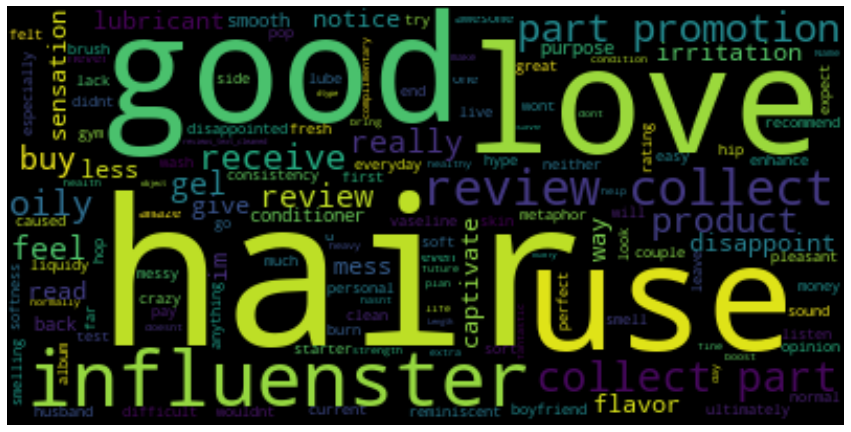

In [369]:
wordcloud = WordCloud(stopwords=stopwords,max_words=200).generate(str(df_clean.reviews_text_cleaned))

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [370]:
def get_top_common_words(reviews, n_most_common):
    # flatten review column into a list of words, and set each to lowercase
    all_words = [word for review in reviews for word in 
                         review.lower().split()]


    # remove punctuation from reviews
    all_words = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in all_words]


    # remove any empty strings that were created by this process
    all_words = [review for review in all_words if review]

    return Counter(all_words).most_common(n_most_common)

In [371]:
pos_reviews = df_clean[df_clean['user_sentiment']==1]
get_top_common_words(pos_reviews['reviews_text_cleaned'],10)

[('great', 14418),
 ('love', 12391),
 ('use', 11945),
 ('product', 11388),
 ('movie', 9878),
 ('review', 8582),
 ('part', 8346),
 ('clean', 7966),
 ('promotion', 7945),
 ('wipe', 7603)]

In [372]:
neg_reviews = df_clean[df_clean['user_sentiment']==0]
get_top_common_words(neg_reviews['reviews_text_cleaned'],10)

[('use', 1557),
 ('product', 1351),
 ('review', 901),
 ('part', 843),
 ('promotion', 801),
 ('movie', 798),
 ('collect', 750),
 ('wipe', 711),
 ('love', 564),
 ('clorox', 562)]

In [373]:
#function to collect the n-gram frequency of words

def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [374]:
# display the top 10 words in the bigram frequency

common_words = get_top_n_ngram(pos_reviews['reviews_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 2]]


,0,1
0,review collect,7536
1,collect promotion,7536
2,clorox wipe,2574
3,great product,1902
4,great movie,1677
5,easy use,1546
6,love clorox,1173
7,love product,1122
8,good movie,954
9,use clorox,948


In [375]:
# display the top 10 words in the bigram frequency

common_words = get_top_n_ngram(neg_reviews['reviews_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 2]]


,0,1
0,review collect,748
1,collect promotion,748
2,clorox wipe,259
3,use product,177
4,old formula,172
5,new formula,163
6,use clorox,154
7,bring old,116
8,great product,111
9,product use,103


In [376]:
# display the top 10 words in the trigram frequency from entire data set

common_words = get_top_n_ngram(df_clean["reviews_text_cleaned"], 3, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 2]]


,0,1
0,review collect promotion,8284
1,love clorox wipe,607
2,use clorox wipe,559
3,clorox disinfect wipe,550
4,review collected promotion,457
5,clean review collect,441
6,use review collect,357
7,product review collect,350
8,great product love,290
9,great movie great,264


<h2>7. Feature Extraction</h2>

In [377]:
X = df_clean['reviews_text_cleaned']
y = df_clean['user_sentiment']

In [378]:
no_of_classes= len(pd.Series(y).value_counts())

In [379]:
for i in range(0,no_of_classes):
    print("Percent of {0}s: ".format(i), round(100*pd.Series(y).value_counts()[i]/pd.Series(y).value_counts().sum(),2), "%")

Percent of 0s:  11.19 %
Percent of 1s:  88.81 %


In [380]:
# using TF-IDF vectorizer using the parameters to get 650 features.


tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=650, max_df=0.9, min_df=7, binary=True, 
                                   ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_clean['reviews_text_cleaned'])

y= df_clean['user_sentiment']

In [381]:
print(tfidf_vectorizer.get_feature_names())

['able', 'absolutely', 'absolutely love', 'act', 'action', 'action movie', 'actor', 'actually', 'add', 'age', 'ago', 'amaze', 'amazing', 'apply', 'area', 'ask', 'available', 'away', 'awesome', 'awesome love', 'awesome movie', 'awesome product', 'awful', 'baby', 'bad', 'bag', 'bathroom', 'bathroom kitchen', 'beautiful', 'bee', 'begin', 'believe', 'best', 'best buy', 'best product', 'big', 'bit', 'black', 'bleach', 'blu', 'blu ray', 'bluray', 'body', 'bottle', 'box', 'boy', 'brand', 'break', 'bring', 'bring cocoa', 'bring old', 'brown', 'burt', 'burt bee', 'buy', 'canister', 'car', 'care', 'carpet', 'carry', 'cast', 'cd', 'chair', 'change', 'character', 'cheap', 'child', 'chip', 'classic', 'classroom', 'clay', 'clean', 'clean bathroom', 'clean disinfect', 'clean easy', 'clean fresh', 'clean great', 'clean house', 'clean kitchen', 'clean love', 'clean mess', 'clean product', 'clean review', 'clean smell', 'clean ups', 'clean use', 'clean wipe', 'cleaner', 'cleaning', 'cleanup', 'clear', '

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [382]:
pickle.dump(tfidf_vectorizer,open(filepath+'pickle_file/tfidf_vectorizer.pkl','wb'))

In [383]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=42, test_size=0.25)

<b>Class imbalance (using SMOTE)</b>

The class difference between the positive and negative user sentiment is very high. Hence we need ti balance the 2 classes

In [384]:
counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({1: 19847, 0: 2499})
After Counter({1: 19847, 0: 19847})


<h2>8. Sentiment Analysis Models</h2>

In [385]:
# Function for Metrics
performance=[]

def model_metrics(y,y_pred,model_name,metrics):
  Accuracy = accuracy_score(y,y_pred)
  roc = roc_auc_score(y,y_pred)
  confusion = confusion_matrix(y,y_pred)
  precision = precision_score(y,y_pred)
  f1 = f1_score(y,y_pred)
  TP = confusion[1,1]  # true positive
  TN = confusion[0,0]  # true negatives
  FP = confusion[0,1]  # false positives
  FN = confusion[1,0]  # false negatives
  sensitivity= TP / float(TP+FN)
  specificity = TN / float(TN+FP)

  print("*"*50)
  print('Confusion Matrix =')
  print(confusion)
  print("sensitivity of the %s = %f" % (model_name,round(sensitivity,2)))
  print("specificity of the %s = %f" % (model_name,round(specificity,2)))
  print("Accuracy Score of %s = %f" % (model_name,Accuracy))
  print('ROC AUC score of %s = %f' % (model_name,roc))
  print("Report=",)
  print(classification_report(y,y_pred))
  print("*"*50)
  metrics.append(dict({'Model_name':model_name,
                       'Accuracy':Accuracy,
                       'Roc_auc_score':roc,
                       'Precision':precision,
                       'F1_score':f1}))
  return metrics


<b>Logistic Regresssion</b>

In [386]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [387]:
y_pred_lr = lr.predict(X_train)
peformance = model_metrics(y_train,y_pred_lr,'Logistic Regression',performance)

**************************************************
Confusion Matrix =
[[17952  1895]
 [ 2169 17678]]
sensitivity of the Logistic Regression = 0.890000
specificity of the Logistic Regression = 0.900000
Accuracy Score of Logistic Regression = 0.897617
ROC AUC score of Logistic Regression = 0.897617
Report=
              precision    recall  f1-score   support

           0       0.89      0.90      0.90     19847
           1       0.90      0.89      0.90     19847

    accuracy                           0.90     39694
   macro avg       0.90      0.90      0.90     39694
weighted avg       0.90      0.90      0.90     39694

**************************************************


In [388]:
# 1. Logsitic Regression 
for c in [0.01, 0.05, 0.25, 0.5, 1, 1.5, 2]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    cm = confusion_matrix(y_test, lr.predict(X_test))
    print('Sensitivity for C = {0} is {1}'.format(c, cm[1][1]/sum(cm[1])))
    print('Specificity for C = {0} is {1}'.format(c, cm[0][0]/sum(cm[0])))

Sensitivity for C = 0.01 is 0.8341647770219199
Specificity for C = 0.01 is 0.6726618705035972
Sensitivity for C = 0.05 is 0.8636432350718065
Specificity for C = 0.05 is 0.6930455635491607
Sensitivity for C = 0.25 is 0.8778533635676493
Specificity for C = 0.25 is 0.6930455635491607
Sensitivity for C = 0.5 is 0.8822373393801966
Specificity for C = 0.5 is 0.6906474820143885
Sensitivity for C = 1 is 0.8870748299319728
Specificity for C = 1 is 0.6918465227817746
Sensitivity for C = 1.5 is 0.8890400604686319
Specificity for C = 1.5 is 0.6882494004796164
Sensitivity for C = 2 is 0.889644746787604
Specificity for C = 2 is 0.6918465227817746


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [389]:
final_lr = LogisticRegression(C=2)
final_lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=2)

In [390]:
y_pred_lr_final = final_lr.predict(X_train)
peformance = model_metrics(y_train,y_pred_lr_final,'Logistic Regression - Tuned',performance)

**************************************************
Confusion Matrix =
[[18030  1817]
 [ 2129 17718]]
sensitivity of the Logistic Regression - Tuned = 0.890000
specificity of the Logistic Regression - Tuned = 0.910000
Accuracy Score of Logistic Regression - Tuned = 0.900590
ROC AUC score of Logistic Regression - Tuned = 0.900590
Report=
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     19847
           1       0.91      0.89      0.90     19847

    accuracy                           0.90     39694
   macro avg       0.90      0.90      0.90     39694
weighted avg       0.90      0.90      0.90     39694

**************************************************


In [391]:
feature_to_coef = {
    word: coef for word, coef in zip(
     tfidf_vectorizer.get_feature_names(), final_lr.coef_[0])
}

print('Positive Words')
for best_positive in sorted(
    feature_to_coef.items(),
    key=lambda x: x[1],
    reverse=True)[:10]:
    print(best_positive)
    
print('Negative Words')
for best_negative in sorted(
    feature_to_coef.items(),
    key=lambda x: x[1])[:10]:
    print(best_negative)


Positive Words
('great', 11.285803283381737)
('best', 9.425047915347893)
('love', 8.233843395833754)
('easy', 7.786533087207064)
('wonderful', 7.376769847692454)
('good', 7.373077926404396)
('perfect', 7.041165726620631)
('enjoy', 6.96303495485839)
('excellent', 6.909084229971261)
('free', 6.61494004831815)
Negative Words
('awful', -6.355084308238827)
('terrible', -5.9310555879138285)
('sick', -5.465057871584136)
('horrible', -5.3351582516633735)
('disappointed', -4.3901467686962885)
('evil', -4.204202197240114)
('hate', -4.141495940823219)
('bad', -4.060512147539535)
('disappoint', -3.191295513277906)
('cold', -2.92608075477022)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<b>RandomForest Classifier</b>

In [392]:
# 2. RandomForest Classifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [393]:
y_pred_rf = rf.predict(X_train)
performance = model_metrics(y_train,y_pred_rf,'RandomForestClassifier',performance)

**************************************************
Confusion Matrix =
[[19812    35]
 [   29 19818]]
sensitivity of the RandomForestClassifier = 1.000000
specificity of the RandomForestClassifier = 1.000000
Accuracy Score of RandomForestClassifier = 0.998388
ROC AUC score of RandomForestClassifier = 0.998388
Report=
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19847
           1       1.00      1.00      1.00     19847

    accuracy                           1.00     39694
   macro avg       1.00      1.00      1.00     39694
weighted avg       1.00      1.00      1.00     39694

**************************************************


As this has very high accuracy and other scores we will try hyper-tuning the random forest

In [394]:
##### Fitting a Random Forest classifier with various hyperparameters
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [15, 20],
    'min_samples_leaf': [100,200],
    'min_samples_split': [200,400],
    'n_estimators': [100, 300]
}

# Create a based model
final_rf = RandomForestClassifier()

# Instantiate the grid search model
rf_tuned = GridSearchCV(estimator = final_rf, param_grid = param_grid, scoring='roc_auc', cv = 3, n_jobs = -1,verbose = 1)
rf_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'min_samples_leaf': [100, 200],
                         'min_samples_split': [200, 400],
                         'n_estimators': [100, 300]},
             scoring='roc_auc', verbose=1)

In [395]:
# print best hyperparameters
print("Best AUC-ROC Score on train data: ", rf_tuned.best_score_)
print("Best hyperparameters: ", rf_tuned.best_params_)

Best AUC-ROC Score on train data:  0.8973102073439844
Best hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 300}


In [396]:
y_pred_rf_tuned = rf_tuned.predict(X_train)
performance = model_metrics(y_train,y_pred_rf_tuned,'RandomForestClassifier-Tuned',performance)

**************************************************
Confusion Matrix =
[[15759  4088]
 [ 2957 16890]]
sensitivity of the RandomForestClassifier-Tuned = 0.850000
specificity of the RandomForestClassifier-Tuned = 0.790000
Accuracy Score of RandomForestClassifier-Tuned = 0.822517
ROC AUC score of RandomForestClassifier-Tuned = 0.822517
Report=
              precision    recall  f1-score   support

           0       0.84      0.79      0.82     19847
           1       0.81      0.85      0.83     19847

    accuracy                           0.82     39694
   macro avg       0.82      0.82      0.82     39694
weighted avg       0.82      0.82      0.82     39694

**************************************************


<b>Naive Bayes Model</b>

In [397]:
# 3. Fitting Naive Bayes Model
nb=MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [398]:
y_pred_nb = nb.predict(X_train)
performance = model_metrics(y_train,y_pred_nb,'NaiveBayes',performance)

**************************************************
Confusion Matrix =
[[15067  4780]
 [ 3812 16035]]
sensitivity of the NaiveBayes = 0.810000
specificity of the NaiveBayes = 0.760000
Accuracy Score of NaiveBayes = 0.783544
ROC AUC score of NaiveBayes = 0.783544
Report=
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     19847
           1       0.77      0.81      0.79     19847

    accuracy                           0.78     39694
   macro avg       0.78      0.78      0.78     39694
weighted avg       0.78      0.78      0.78     39694

**************************************************


<b>XGBoost Classifier</b>

In [399]:
# 3. Fitting XGBoost classifier

xgb = XGBClassifier(booster='gbtree')
xgb.fit(X_train, y_train)

XGBClassifier()

In [400]:
y_pred_xgb = xgb.predict(X_train)
performance = model_metrics(y_train,y_pred_xgb,'XGBoostClassifier',performance)

**************************************************
Confusion Matrix =
[[16285  3562]
 [ 2868 16979]]
sensitivity of the XGBoostClassifier = 0.860000
specificity of the XGBoostClassifier = 0.820000
Accuracy Score of XGBoostClassifier = 0.838011
ROC AUC score of XGBoostClassifier = 0.838011
Report=
              precision    recall  f1-score   support

           0       0.85      0.82      0.84     19847
           1       0.83      0.86      0.84     19847

    accuracy                           0.84     39694
   macro avg       0.84      0.84      0.84     39694
weighted avg       0.84      0.84      0.84     39694

**************************************************


In [401]:
#Hyper tuning xgboost

param_grid = {'learning_rate': [0.001, 0.01], 'max_depth':[ 5, 10],  'n_estimators':[1, 3]}

final_xgb = XGBClassifier(booster='gbtree')

# set up GridSearchCV()
xgb_tuned = GridSearchCV(estimator = final_xgb, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv =3, 
                        verbose = 1,
                        return_train_score=True)

xgb_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.001, 0.01], 'max_depth': [5, 10],
                         'n_estimators': [1, 3]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [402]:
# print best hyperparameters
print("Best AUC-ROC Score on train data: ", xgb_tuned.best_score_)
print("Best hyperparameters: ", xgb_tuned.best_params_)

Best AUC-ROC Score on train data:  0.860884548308424
Best hyperparameters:  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 3}


In [403]:
y_pred_xgb_tuned = xgb_tuned.predict(X_train)
performance = model_metrics(y_train,y_pred_xgb_tuned,'XGBoostClassifier-Tuned',performance)

**************************************************
Confusion Matrix =
[[15979  3868]
 [ 3118 16729]]
sensitivity of the XGBoostClassifier-Tuned = 0.840000
specificity of the XGBoostClassifier-Tuned = 0.810000
Accuracy Score of XGBoostClassifier-Tuned = 0.824004
ROC AUC score of XGBoostClassifier-Tuned = 0.824004
Report=
              precision    recall  f1-score   support

           0       0.84      0.81      0.82     19847
           1       0.81      0.84      0.83     19847

    accuracy                           0.82     39694
   macro avg       0.82      0.82      0.82     39694
weighted avg       0.82      0.82      0.82     39694

**************************************************


<b>Evaluate all the models with test data set</b>

In [404]:
#Evaluatopn between lr , rf, nb and boost 
test_performance=[]

y_test_pred_lr_final = final_lr.predict(X_test)
test_peformance = model_metrics(y_test,y_test_pred_lr_final,'Logistic Regression - Tuned',test_performance)

y_test_pred_rf = rf.predict(X_test)
test_peformance = model_metrics(y_test,y_test_pred_rf,'Random Forest',test_performance)

y_test_pred_rf_tuned = rf_tuned.predict(X_test)
test_peformance = model_metrics(y_test,y_test_pred_rf_tuned,'Random Forest - Tuned',test_performance)

y_test_pred_nb = nb.predict(X_test)
test_peformance = model_metrics(y_test,y_test_pred_nb,'Naive Bayes',test_performance)

y_test_pred_xgb = xgb.predict(X_test)
test_peformance = model_metrics(y_test,y_test_pred_xgb,'XGBoost Classifier',test_performance)

y_test_pred_xgb_tuned = xgb_tuned.predict(X_test)
test_peformance = model_metrics(y_test,y_test_pred_xgb_tuned,'XGBoost Classifier - Tuned',test_performance)

test_metrics_df = pd.DataFrame(test_performance)
test_metrics_df

**************************************************
Confusion Matrix =
[[ 577  257]
 [ 730 5885]]
sensitivity of the Logistic Regression - Tuned = 0.890000
specificity of the Logistic Regression - Tuned = 0.690000
Accuracy Score of Logistic Regression - Tuned = 0.867499
ROC AUC score of Logistic Regression - Tuned = 0.790746
Report=
              precision    recall  f1-score   support

           0       0.44      0.69      0.54       834
           1       0.96      0.89      0.92      6615

    accuracy                           0.87      7449
   macro avg       0.70      0.79      0.73      7449
weighted avg       0.90      0.87      0.88      7449

**************************************************
**************************************************
Confusion Matrix =
[[ 414  420]
 [ 305 6310]]
sensitivity of the Random Forest = 0.950000
specificity of the Random Forest = 0.500000
Accuracy Score of Random Forest = 0.902671
ROC AUC score of Random Forest = 0.725148
Report=
          

,Model_name,Accuracy,Roc_auc_score,Precision,F1_score
0,Logistic Regression - Tuned,0.867499,0.790746,0.958157,0.922631
1,Random Forest,0.902671,0.725148,0.937593,0.945673
2,Random Forest - Tuned,0.817291,0.722658,0.943750,0.891424
3,Naive Bayes,0.790844,0.738679,0.951115,0.872504
4,XGBoost Classifier,0.828433,0.744649,0.949016,0.898232
5,XGBoost Classifier - Tuned,0.804672,0.711885,0.941781,0.883179


Based on the train and test ROC AUC values the "Logistic Regression" model is the best.

Saving the Logistic Regression model

In [405]:
pickle.dump(lr,open(filepath+'pickle_file/lr_model.pkl','wb'))

<h1>Recommedation system</h2>

* User and User recommedation system
* Item and Item recommedation system

<h2>1. Load Data</h2>

In [7]:
df = pd.read_csv(filepath + 'sample30.csv')
df.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive


<h2>2. Data preprocessing</h2>

In [8]:
df['reviews_rating'].describe()

count    30000.000000
mean         4.483133
std          0.988441
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reviews_rating, dtype: float64

In [9]:
ratings= df[['name', 'reviews_rating', 'reviews_username']]

In [10]:
ratings.head()

,name,reviews_rating,reviews_username
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,K-Y Love Sensuality Pleasure Gel,1,walker557


In [11]:
# Checking for null values
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              30000 non-null  object
 1   reviews_rating    30000 non-null  int64 
 2   reviews_username  29937 non-null  object
dtypes: int64(1), object(2)
memory usage: 703.2+ KB


In [12]:
ratings = ratings[~ratings.reviews_username.isna()]

In [13]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29937 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              29937 non-null  object
 1   reviews_rating    29937 non-null  int64 
 2   reviews_username  29937 non-null  object
dtypes: int64(1), object(2)
memory usage: 935.5+ KB


In [14]:
train,test = train_test_split(ratings,train_size=0.70,random_state=45)
print('train shape = ',train.shape)
print('test shape = ',test.shape)

train shape =  (20955, 3)
test shape =  (8982, 3)


In [15]:
train.name.nunique()

253

In [16]:
train.reviews_username.nunique()

18279

In [17]:
# Pivot the train ratings' dataset into matrix format in which columns are products and the rows are user IDs.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_pivot.shape

(18279, 253)

<h2>3. Creating dummy train & dummy test dataset</h2>

In [19]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [20]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [21]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)


dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
dummy_train.shape

(18279, 253)

<h2>4. User Similarity Matrix</h2>

### Using Cosine Similarity

In [23]:
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [24]:
user_correlation.shape

(18279, 18279)

### Using adjusted Cosine

In [25]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)

In [26]:
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the rating of the movie for each user around 0 mean

In [27]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [28]:
df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity

In [29]:
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Prediction:

In [30]:
user_correlation.shape

(18279, 18279)

In [31]:
# Removing negative rating
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.76699295, 0.        , ..., 2.04124145, 0.42640143,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [33]:
user_predicted_ratings.shape

(18279, 253)

In [34]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
00sab00,0.0,2.766993,0.0,0.0,0.0,0.0,0.0,0.0,2.69408,0.0,...,0.0,0.816497,0.0,0.0,0.0,1.997794,0.0,2.041241,0.426401,0.0
02deuce,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0


### **Find the top 5 recommendation for the user**

In [35]:
user_input = str('00sab00') # for checking

In [36]:
# Recommended products for the selected user based on ratings
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd        43.252729
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)    20.430674
The Resident Evil Collection 5 Discs (blu-Ray)                         13.304777
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total               8.275788
Red (special Edition) (dvdvideo)                                        6.920321
Name: 00sab00, dtype: float64

# **Evaluation - User User**

In [37]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(2038, 3)

In [38]:
common.head()

,name,reviews_rating,reviews_username
17982,Vaseline Intensive Care Lip Therapy Cocoa Butter,5,nnc29
12150,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,azu12
21326,Nexxus Exxtra Gel Style Creation Sculptor,1,ljb0930
12624,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,ryswife06
1618,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),4,raindq


In [39]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', 
                                              values='reviews_rating')

In [40]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [41]:
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18269,18270,18271,18272,18273,18274,18275,18276,18277,18278
userId,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
common.head(1)

,name,reviews_rating,reviews_username
17982,Vaseline Intensive Care Lip Therapy Cocoa Butter,5,nnc29


In [43]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [44]:
user_correlation_df_1.shape

(1713, 18279)

In [45]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [46]:
user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3.head()

,1234,143st,1943,1witch,37f5p,4 rooms 1 dog lotsa fur,50cal,7.87E+11,aac06002,aalyah,...,yeyo,ygtz,yoadrian,yshan,yucky111,yvonne,zebras,zipper,zippy,zmom
userId,,,,,,,,,,,,,,,,,,,,,
1234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
user_correlation_df_3.shape

(1713, 1713)

In [48]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[1.15470054, 0.        , 0.        , ..., 3.90261939, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [49]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [50]:
dummy_test.shape

(1713, 127)

In [51]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings

name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",...,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yvonne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zebras,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zipper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Find rmse :

In [52]:
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [53]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [54]:
common_.head()

name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",...,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
common_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1713 entries, 1234 to zmom
Columns: 127 entries, 100:Complete First Season (blu-Ray) to Yes To Grapefruit Rejuvenating Body Wash
dtypes: float64(127)
memory usage: 1.7+ MB


In [56]:
y

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [57]:
y.shape

(1713, 127)

below analysis is because. i was getting error while calculating rmse

In [58]:
y.sum()

nan

In [59]:
common_.sum()

name
100:Complete First Season (blu-Ray)                                                                         50.0
42 Dual Drop Leaf Table with 2 Madrid Chairs"                                                                5.0
Africa's Best No-Lye Dual Conditioning Relaxer System Super                                                  4.0
Alex Cross (dvdvideo)                                                                                       35.0
All,bran Complete Wheat Flakes, 18 Oz.                                                                       5.0
                                                                                                           ...  
Vicks Vaporub, Regular, 3.53oz                                                                              19.0
Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee      5.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                                      

In [60]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [61]:
total_non_nan

319

In [62]:
((common_ - y )**2).info()

<class 'pandas.core.frame.DataFrame'>
Index: 1713 entries, 1234 to zmom
Columns: 127 entries, 100:Complete First Season (blu-Ray) to Yes To Grapefruit Rejuvenating Body Wash
dtypes: float64(127)
memory usage: 1.7+ MB


In [63]:
y

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [64]:
common_

name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",...,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zebras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
'''y = np.nan_to_num(y)
print(y)'''

'y = np.nan_to_num(y)\nprint(y)'

In [66]:
y.sum()

nan

In [67]:
y.dtype

dtype('float64')

In [68]:
'''common_ = common_.fillna(0)'''

'common_ = common_.fillna(0)'

In [69]:
common_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1713 entries, 1234 to zmom
Columns: 127 entries, 100:Complete First Season (blu-Ray) to Yes To Grapefruit Rejuvenating Body Wash
dtypes: float64(127)
memory usage: 1.7+ MB


In [70]:
common_.sum()

name
100:Complete First Season (blu-Ray)                                                                         50.0
42 Dual Drop Leaf Table with 2 Madrid Chairs"                                                                5.0
Africa's Best No-Lye Dual Conditioning Relaxer System Super                                                  4.0
Alex Cross (dvdvideo)                                                                                       35.0
All,bran Complete Wheat Flakes, 18 Oz.                                                                       5.0
                                                                                                           ...  
Vicks Vaporub, Regular, 3.53oz                                                                              19.0
Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee      5.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                                      

In [71]:
common_ - y

name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",...,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zebras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
common_.columns

Index(['100:Complete First Season (blu-Ray)',
       '42 Dual Drop Leaf Table with 2 Madrid Chairs"',
       'Africa's Best No-Lye Dual Conditioning Relaxer System Super',
       'Alex Cross (dvdvideo)', 'All,bran Complete Wheat Flakes, 18 Oz.',
       'Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular',
       'Aussie Aussome Volume Shampoo, 13.5 Oz',
       'Australian Gold Exotic Blend Lotion, SPF 4',
       'Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz',
       'Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter',
       ...
       'Various - Country's Greatest Gospel:Gold Ed (cd)',
       'Various - Red Hot Blue:Tribute To Cole Porter (cd)',
       'Various Artists - Choo Choo Soul (cd)',
       'Vaseline Intensive Care Healthy Hands Stronger Nails',
       'Vaseline Intensive Care Lip Therapy Cocoa Butter',
       'Vicks Vaporub, Regular, 3.53oz',
       'Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf,

In [73]:
common_.index

Index(['1234', '143st', '1943', '1witch', '37f5p', '4 rooms 1 dog lotsa fur',
       '50cal', '7.87E+11', 'aac06002', 'aalyah',
       ...
       'yeyo', 'ygtz', 'yoadrian', 'yshan', 'yucky111', 'yvonne', 'zebras',
       'zipper', 'zippy', 'zmom'],
      dtype='object', name='reviews_username', length=1713)

In [74]:
print(y.shape)

(1713, 127)


In [75]:
common_.shape

(1713, 127)

In [76]:
'''sum((common_ - y)**2)'''

'sum((common_ - y)**2)'

In [77]:
(common_ - y).sum()

name
100:Complete First Season (blu-Ray)                                                                        9.991624
42 Dual Drop Leaf Table with 2 Madrid Chairs"                                                              0.000000
Africa's Best No-Lye Dual Conditioning Relaxer System Super                                                0.000000
Alex Cross (dvdvideo)                                                                                      6.000000
All,bran Complete Wheat Flakes, 18 Oz.                                                                     4.000000
                                                                                                             ...   
Vicks Vaporub, Regular, 3.53oz                                                                             4.000000
Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee    0.000000
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)              

In [78]:
(common_ - y)**2

name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",...,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zebras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zipper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
((common_ - y)**2).sum()

name
100:Complete First Season (blu-Ray)                                                                        25.465958
42 Dual Drop Leaf Table with 2 Madrid Chairs"                                                               0.000000
Africa's Best No-Lye Dual Conditioning Relaxer System Super                                                 0.000000
Alex Cross (dvdvideo)                                                                                      18.000000
All,bran Complete Wheat Flakes, 18 Oz.                                                                     16.000000
                                                                                                             ...    
Vicks Vaporub, Regular, 3.53oz                                                                             16.000000
Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee     0.000000
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)      

In [80]:
'''rmse_user = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_user)'''

'rmse_user = (sum(sum((common_ - y )**2))/total_non_nan)**0.5\nprint(rmse_user)'

In [81]:
rmse_user = (sum(((common_ - y)**2).sum())/total_non_nan)**0.5
print(rmse_user)

2.521107225981535


---------------------------------- End of User - User based similarity ----------------------------------

## Item Based Similarity

In [82]:
# take transpose of user based df
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00dog3,00sab00,02deuce,0325home,06stidriver,08dallas,09mommy11,1085,10ten,1234,...,zout22389,zowie,zpalma,zsarah,zsazsa,zt313,zuttle,zxcsdfd,zxjki,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the movie rating for each movie for using the Adujsted Cosine

In [83]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

reviews_username,00dog3,00sab00,02deuce,0325home,06stidriver,08dallas,09mommy11,1085,10ten,1234,...,zout22389,zowie,zpalma,zsarah,zsazsa,zt313,zuttle,zxcsdfd,zxjki,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,0.282828,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ... -0.00433013  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00433013  0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


In [85]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Predicition

In [86]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02640447, 0.        , ..., 0.        , 0.00371817,
        0.0021939 ],
       ...,
       [0.        , 0.00254773, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00101909, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00203818, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [87]:
item_predicted_ratings.shape

(18279, 253)

In [88]:
dummy_train.shape

(18279, 253)

Filter the rating only for the products not rated by the user for recommendation.

In [89]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
00sab00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.038263,0.000000,...,0.0,0.035270,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
02deuce,0.0,0.026404,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.012416,0.0,0.0,0.010671,0.007669,0.0,0.0,0.003718,0.002194
0325home,0.0,0.002548,0.0,0.0,0.0,0.0,0.0,0.0,0.002393,0.002852,...,0.0,0.000000,0.0,0.0,0.008856,0.000000,0.0,0.0,0.000000,0.000000
06stidriver,0.0,0.002548,0.0,0.0,0.0,0.0,0.0,0.0,0.002393,0.002852,...,0.0,0.000000,0.0,0.0,0.008856,0.000000,0.0,0.0,0.000000,0.000000


In [90]:
# Take the user ID as input [bob,00sab00]
#user_input = str(input("Enter your user name"))
user_input = str('00sab00') # for checking

In [91]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:10]
d

name
Vicks Vaporub, Regular, 3.53oz                                  0.140290
Bilbao Nightstand Gray Oak - South Shore                        0.134173
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)    0.113744
Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White          0.076488
D-Con Mice Bait Station - 3ct                                   0.054438
Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans                 0.043620
Alex Cross (dvdvideo)                                           0.038263
Wagan Smartac 80watt Inverter With Usb                          0.035270
Iman Second To None Stick Foundation, Clay 1                    0.022078
Moom Express Pre Waxed Strips For Face & Bikini                 0.019318
Name: 00sab00, dtype: float64

### Evaluation:

In [92]:
common =  test[test.name.isin(train.name)]
common.shape

(8962, 3)

In [93]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T
common_item_based_matrix.shape

(206, 8332)

In [94]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
list_name = common.name.tolist()

In [97]:
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [98]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head(3)

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01980335, 0.03300559, 0.00254773, ..., 0.00254773, 0.00254773,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00278863, 0.00464771, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00164543, 0.00274238, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [100]:
common_item_predicted_ratings.shape

(206, 8332)

Create a dummy for test data set

In [101]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [102]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

### Find rmse:

In [103]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [104]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [105]:
'''rmse_item = round((sum(sum((common_ - y )**2))/total_non_nan)**0.5,2)
print(rmse_item)'''

'rmse_item = round((sum(sum((common_ - y )**2))/total_non_nan)**0.5,2)\nprint(rmse_item)'

In [106]:
rmse_user = (sum(((common_ - y)**2).sum())/total_non_nan)**0.5
print(rmse_user)

3.5726735149298046


### Selecting Recommendation system and Saving 

* User-User rmse: 2.52
* Item-Item remse: 3.57

User-user based model is the better model. Saving the pickle file

In [108]:
pickle.dump(user_final_rating, open(filepath+'pickle_file/user_based_recomm_model.pkl','wb'))

# Recommendation of Top 20 Products to a Specified User

In [110]:
# load all pkl files
tfidf_model = pickle.load(open(filepath+'pickle_file/tfidf_vectorizer.pkl', 'rb'))
user_based_recomm_model = pickle.load(open(filepath+'pickle_file/user_based_recomm_model.pkl', 'rb'))
LR_model = pickle.load(open(filepath+'pickle_file/lr_model.pkl', 'rb'))

In [111]:
user = str('00sab00') # test user

In [112]:
# Recommend top 20 products
user_top20 = user_based_recomm_model.loc[user].sort_values(ascending=False)[:20]

In [113]:
user_top20 = pd.DataFrame(user_top20)  #.to_records())
user_top20.reset_index(inplace = True)
user_top20

,name,00sab00
0,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,43.252729
1,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),20.430674
2,The Resident Evil Collection 5 Discs (blu-Ray),13.304777
3,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8.275788
4,Red (special Edition) (dvdvideo),6.920321
5,Clorox Disinfecting Bathroom Cleaner,5.977308
6,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,5.076394
7,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),4.553944
8,Tostitos Bite Size Tortilla Chips,4.311190
9,"Hormel Chili, No Beans",3.871591


Cleaning the dataframe

In [114]:
df = pd.read_csv(filepath + 'sample30.csv')
df.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive


In [115]:
df['user_sentiment']= df['user_sentiment'].apply(lambda x:1 if x=='Positive' else 0)
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,1
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,1
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,1
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensatio...",Disappointed,NaN,NaN,rebecca,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,0


In [116]:
# Replace nulls 
df['reviews_title'].fillna('',inplace=True)

In [117]:
# merge reviews columns
df['reviews']=df['reviews_text']+df['reviews_title']
df.drop(['reviews_text','reviews_title'],axis=1,inplace=True)
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,Los Angeles,NaN,joshua,1,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.Just Awesome
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,NaN,NaN,dorothy w,1,Good flavor. This review was collected as part of a promotion.Good
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,NaN,NaN,dorothy w,1,Good flavor.Good
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,NaN,NaN,rebecca,0,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensatio..."
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,NaN,NaN,walker557,0,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.Irritation


In [118]:
# df_clean -> cleaned columns for recommendation and sentiment models
df_clean = df[['name','reviews_username','reviews','reviews_rating','user_sentiment']]
df_clean.head()

,name,reviews_username,reviews,reviews_rating,user_sentiment
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.Just Awesome,5,1
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,Good flavor. This review was collected as part of a promotion.Good,5,1
2,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,Good flavor.Good,5,1
3,K-Y Love Sensuality Pleasure Gel,rebecca,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensatio...",1,0
4,K-Y Love Sensuality Pleasure Gel,walker557,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.Irritation,1,0


In [119]:
df_clean.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [120]:
df_clean.shape

(29937, 5)

In [122]:
#save the df_clean dataframe

df_clean.to_csv(filepath + 'df_clean.csv')

Merge the clean data set with the recommended products for the user

In [127]:
df_clean = pd.read_csv(filepath + 'df_clean.csv')
df_clean.head(2)

,Unnamed: 0,name,reviews_username,reviews,reviews_rating,user_sentiment
0,0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.Just Awesome,5,1
1,1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,Good flavor. This review was collected as part of a promotion.Good,5,1


In [128]:
df_clean.sample()

,Unnamed: 0,name,reviews_username,reviews,reviews_rating,user_sentiment
4359,4372,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,catalpa,Great pick-up suction and light enough for small female to carry. Have recommended it to others.lightweight as promised!,5,1


In [129]:
# merge top 20 products and its reviews
top20_products_setiment = pd.merge(user_top20,df_clean,on = ['name'])
top20_products_setiment.head()

,name,00sab00,Unnamed: 0,reviews_username,reviews,reviews_rating,user_sentiment
0,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,43.252729,22884,primoconcept,could have left this one on the shelf but it had a great boxawful,1,1
1,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,43.252729,22885,terrym,"This movie is much worse that expected. The 1997 Broderick movie is much better. The producers went back to the popular Japanese format that were great for teenagers, but just doesn't work for adults.Much worse than expected",1,1
2,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,43.252729,22886,mrme,"Just don't get the hype about Godzilla. Frankly movie was boring, build up was slow and just not interesting or even worth it. I was even more disappointed to hear Pacific Rim 2 was put on hold for Godzilla vs King Kong if its anything like this movie I'll pass. Oh and because a movie is like the original doesn't make it good, times have changed and an update to the story would work for the new generations.Just dont get the hype",1,0
3,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,43.252729,22887,3dknights,A little disappointed its not like the Godzilla movies years back.Not the best item,1,0
4,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,43.252729,22888,master,"It was on sale, so I bought it. After I got it the case was broken in half witch sucks a lot. But at least the disk are ok I guess. Will not order online if this happens.Good movie, bad packaging.",1,0


Pass 'top20_products' into tfidf model first and into sentiment model to find sentiment score.

In [130]:
# convert text to feature
top20_products_tfidf = tfidf_model.transform(top20_products_setiment['reviews'])

In [131]:
# model prediction
top20_products_pred =LR_model.predict(top20_products_tfidf)
top20_products_pred

array([1, 1, 1, ..., 1, 1, 0])

In [132]:
top20_products_setiment['top20_products_pred']=top20_products_pred

senti_score is given by the percentage of positive reviews to the total reviews for each products.

In [133]:
senti_score = top20_products_setiment.groupby(['name'])['top20_products_pred'].agg(['sum','count']).reset_index()
senti_score['percent'] = round((100*senti_score['sum'] / senti_score['count']),2)
senti_score.head()

,name,sum,count,percent
0,100:Complete First Season (blu-Ray),111,139,79.86
1,"Burt's Bees Lip Shimmer, Raisin",658,873,75.37
2,Chester's Cheese Flavored Puffcorn Snacks,114,177,64.41
3,Clorox Disinfecting Bathroom Cleaner,1699,2039,83.33
4,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,6116,8525,71.74


In [134]:
senti_score

,name,sum,count,percent
0,100:Complete First Season (blu-Ray),111,139,79.86
1,"Burt's Bees Lip Shimmer, Raisin",658,873,75.37
2,Chester's Cheese Flavored Puffcorn Snacks,114,177,64.41
3,Clorox Disinfecting Bathroom Cleaner,1699,2039,83.33
4,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,6116,8525,71.74
5,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),187,247,75.71
6,Eagle Fat Free Sweetened Condensed Milk,11,15,73.33
7,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2680,3325,80.60
8,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,17,32,53.12
9,"Hormel Chili, No Beans",128,196,65.31


## Top 5 products:

In [135]:
senti_score = senti_score.sort_values(by='percent',ascending=False)
senti_score

,name,sum,count,percent
16,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),168,186,90.32
15,Red (special Edition) (dvdvideo),576,672,85.71
18,There's Something About Mary (dvd),109,130,83.85
3,Clorox Disinfecting Bathroom Cleaner,1699,2039,83.33
7,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2680,3325,80.60
0,100:Complete First Season (blu-Ray),111,139,79.86
14,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),883,1143,77.25
5,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),187,247,75.71
1,"Burt's Bees Lip Shimmer, Raisin",658,873,75.37
6,Eagle Fat Free Sweetened Condensed Milk,11,15,73.33


In [136]:
senti_score['name'].head().tolist()

["Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)",
 'Red (special Edition) (dvdvideo)',
 "There's Something About Mary (dvd)",
 'Clorox Disinfecting Bathroom Cleaner',
 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd']